In [29]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('geo_data_0.csv')
df1 = pd.read_csv('geo_data_1.csv')
df2 = pd.read_csv('geo_data_2.csv')

In [26]:
df.sample(20)
df[df['id'].duplicated()]
df[df['id'] == 'HZww2']
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
(np.float64(-0.00033691297345175126), np.float64(0.0007166090877695479), np.float64(-0.0029962585634681917), np.float64(0.004816213270019428))


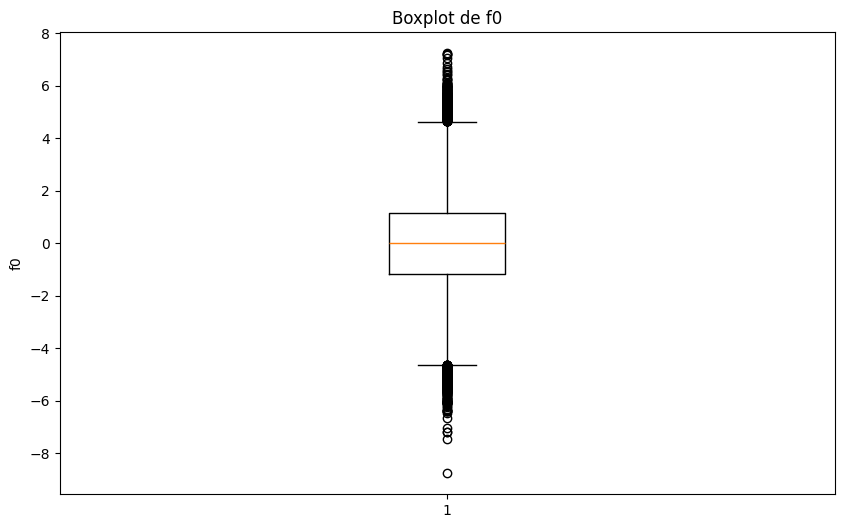

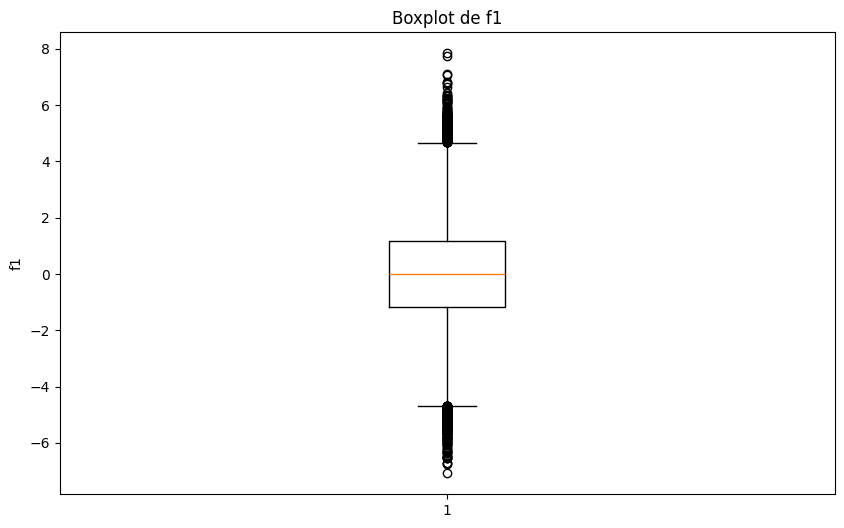

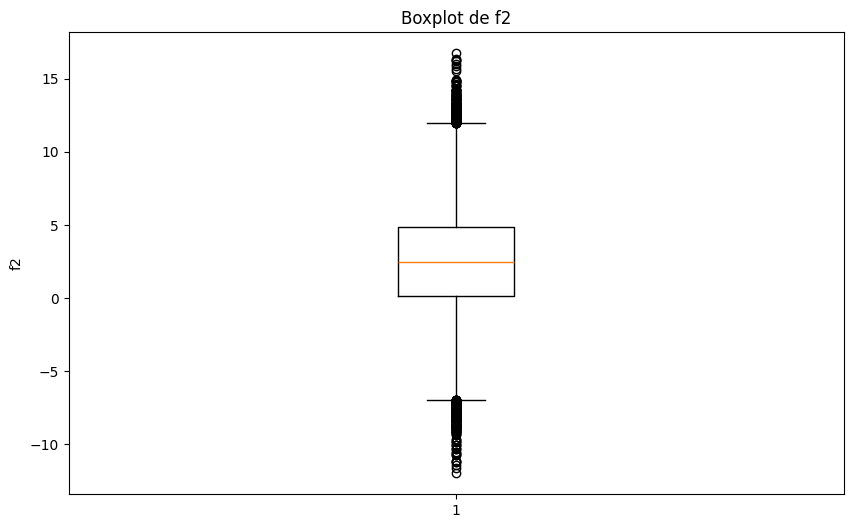

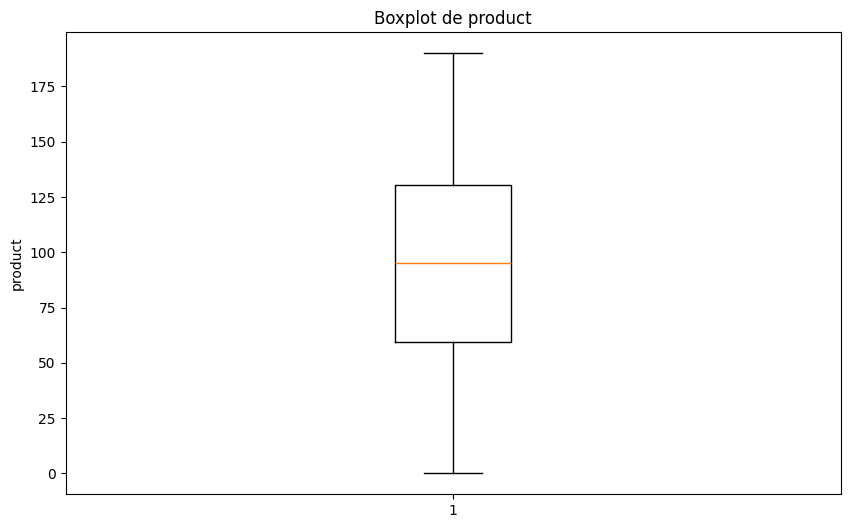

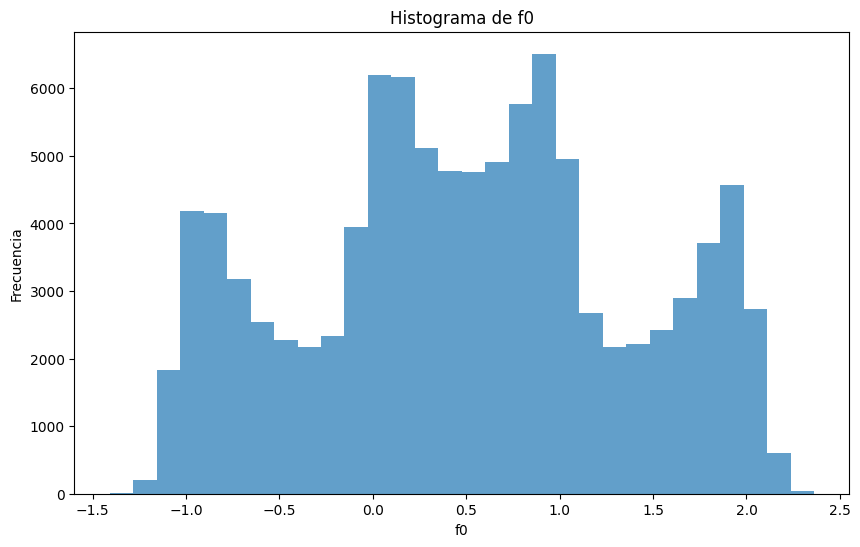

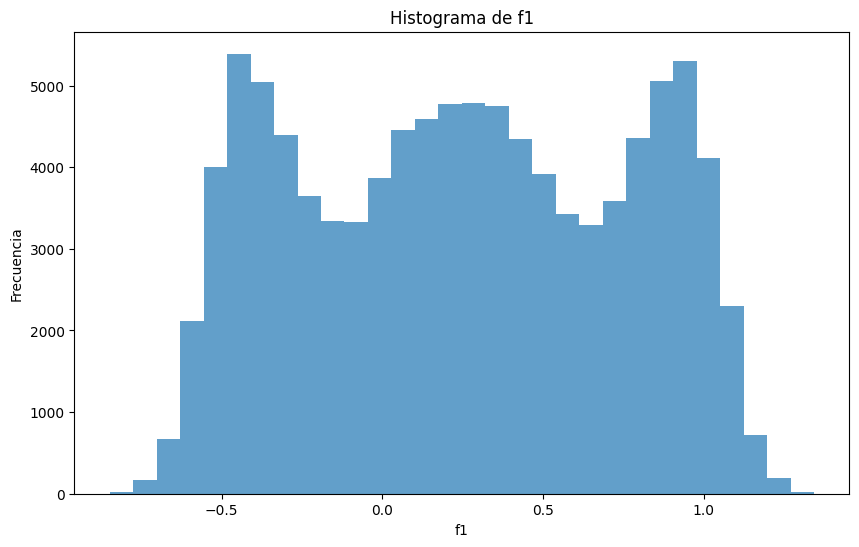

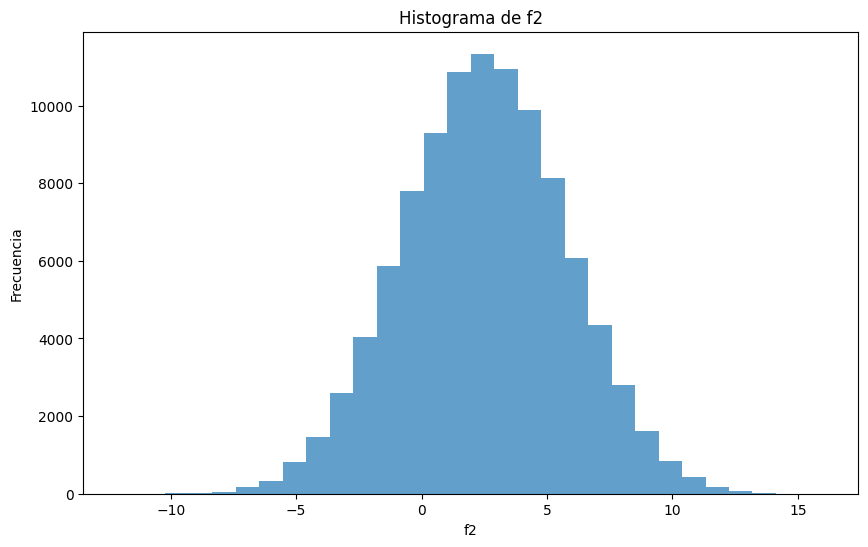

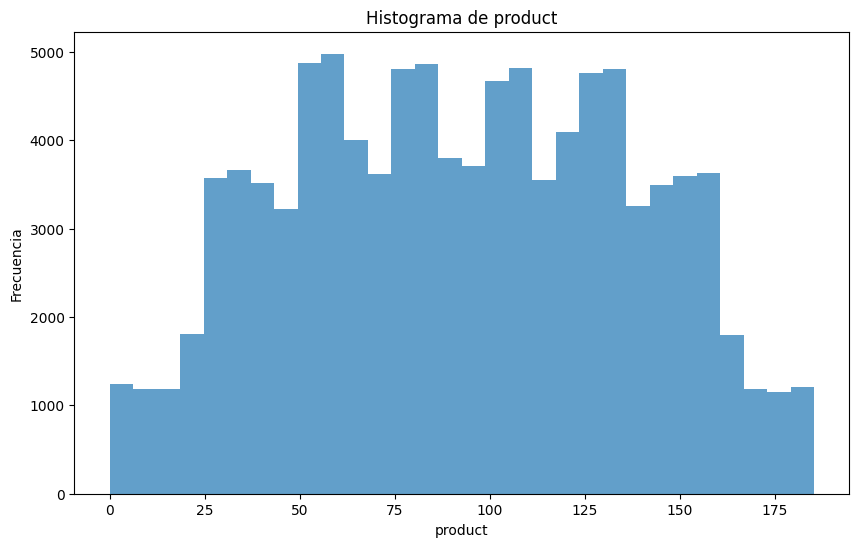

In [31]:
df1.sample(20)
df1[df1['id'].duplicated()]
df1[df1['id'] == 'LHZR0']
df1.info()
sesgo_f0 = df['f0'].skew()
sesgo_f1 = df['f1'].skew()
sesgo_f2 = df['f2'].skew()
sesgo_product = df['product'].skew()
print(f"{sesgo_f0, sesgo_f1, sesgo_f2, sesgo_product}")
for column in ['f0', 'f1', 'f2', 'product']:
    plt.figure(figsize=(10, 6))
    plt.boxplot(data[column])
    plt.title(f'Boxplot de {column}')
    plt.ylabel(column)
    plt.show()
    
for column in ['f0', 'f1', 'f2', 'product']:
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=30, alpha=0.7)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

In [6]:
df2.sample(20)
df2[df2['id'].duplicated()]
df2[df2['id'] == 'xCHr8']

,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Se han examinado los 3 archivos csv y al parecer no hay ningun problema con ninguno, y los ids duplicados que hay es por la diferencia de region. Por lo tanto parecen estar listos para lo siguiente.

In [7]:
features = df[['f0', 'f1', 'f2']]
target = df['product']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

model =LinearRegression() # inicializa el constructor de modelos
model.fit(features_train, target_train) # entrena el modelo en el conjunto de entrenamiento
predictions_valid = model.predict(features_valid) # obtén las predicciones del modelo en el conjunto de validación

result =mean_squared_error(target_valid, predictions_valid)**0.5 # calcula la RECM en el conjunto de validación
print("RECM del modelo de regresión lineal en el conjunto de validación:", result)
mean_prediction = predictions_valid.mean()
print("Volumen medio de las reservas: ", mean_prediction)

RECM del modelo de regresión lineal en el conjunto de validación: 37.5794217150813
Volumen medio de las reservas:  92.59256778438035


En lo anterior dividi los datos para el conjunto de entrenamiento y el de validacion, y tengo las respuestas validas en target_valid y las predicciones en predictions_valid, tambien se calculo el rmse y el volumen medio de las reservas.

El analisis de esta parte es el siguiente:

RECM (Raíz Cuadrada del Error Cuadrático Medio):
RECM: 37.58
La RECM de aproximadamente 37.58 indica el error promedio entre las reservas reales y las predichas por el modelo.
A menor valor de RECM, mejor es el rendimiento del modelo en cuanto a precisión de las predicciones.
Volumen Medio de las Reservas Predicho:
Volumen medio: 92.59 
El volumen medio de reservas predicho es de aproximadamente 92.59. Este es el promedio esperado basado en las características (f0, f1, f2) utilizadas en el modelo.

Ahora procedere a hacer todo esto en funciones para usarlas con los 3 archivos. Tambien hacer la comparacion del volumen medio con el umbral que se menciona en el proyecto, al mismo tiempo estoy mostrando los 200 pozos con valores mas altos por region, uso tambien el volumen para mostrar predicciones en cada una de las regiones por ultimo calculando las ganancias potenciales de cada una de las regiones, haciendo esto se noto que ninguna alcanza el umbral pero la region 3 es la que tiene las mayores ganancias.

In [44]:
# Función 1: Dividir en Conjuntos
def split_data(df, target_col):
    features = df[['f0', 'f1', 'f2']]
    target = df['product']
    return train_test_split(features, target, test_size=0.25, random_state=12345)

# Función 2: Entrenar Modelo
def train_model(features_train, target_train):
    model = LinearRegression()
    model.fit(features_train, target_train)
    return model

# Función 3: Evaluar Modelo
def evaluate_model(model, features_valid, target_valid):
    predictions = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predictions) ** 0.5
    mean_prediction = predictions.mean()
    return rmse, mean_prediction


# Función 4: Comparar volumen medio con el umbral
def compare_to_threshold(mean_prediction, threshold=111.1):
    if mean_prediction >= threshold:
        return f"El volumen medio de reservas ({mean_prediction}) es suficiente para evitar pérdidas."
    else:
        return f"El volumen medio de reservas ({mean_prediction}) es insuficiente para evitar pérdidas."

#Calcula el riesgo de perdidas
def calculate_loss_risk(mean_prediction, threshold=111.1):
    return (mean_prediction < threshold).mean() 


# Función 5: Seleccionar los mejores 200 pozos de todas las zonas
def select_top_pozos(df, top_n=200):
    df_sorted = df.sort_values(by='product', ascending=False)
    return df_sorted.head(top_n)

# Función 6: Calcular ganancia potencial
def calculate_potential_gain(df, price_per_unit=100):
    total_gain = sum(df['product'] * price_per_unit)
    return total_gain

def bootstrapping(predictions, num_samples=1000, confidence=0.95):
    # Generar estado aleatorio
    state = np.random.RandomState(12345)

    # Almacenar los valores del cuantil deseado (por ejemplo, 99%)
    values = []
    for i in range(num_samples):
        subsample = predictions.sample(frac=1, replace=True, random_state=state)
        values.append(subsample.quantile(0.99))

    values = pd.Series(values)

    # Cálculo del intervalo de confianza
    lower = values.quantile((1 - confidence) / 2)
    upper = values.quantile(1 - (1 - confidence) / 2)

    return lower, upper

# Función 7: Procesar una región completa
def process_region(df, region_name, price_per_unit=100):
    # Dividir datos
    features_train, features_valid, target_train, target_valid = split_data(df, 'product')
    
    # Entrenar y evaluar el modelo
    model = train_model(features_train, target_train)
    rmse, mean_prediction = evaluate_model(model, features_valid, target_valid)
    
    # Seleccionar los mejores pozos
    top_pozos = select_top_pozos(df)
    
    # Calcular ganancia potencial
    ganancia_potencial = calculate_potential_gain(top_pozos, price_per_unit)
    
    lower, upper = bootstrapping(pd.Series(top_pozos['product'].values))
    loss_risk = calculate_loss_risk(mean_prediction)

    
    print(f"\nResultados para {region_name}:")
    print(f"Volumen medio de reservas: {mean_prediction}")
    print(f"RMSE: {rmse}")
    print(compare_to_threshold(mean_prediction))
    print(f"Ganancia potencial: {ganancia_potencial}")
    print(f"95% Confidence Interval: Lower = {lower}, Upper = {upper}")
    print(f"Riesgo de Pérdidas: {loss_risk * 100:.2f}%")

    
    return {
        "region": region_name,
        "rmse": rmse,
        "mean_prediction": mean_prediction,
        "ganancia": ganancia_potencial
    }

# Datos de entrada por región
regiones_data = {
    "Region1": df,
    "Region2": df1,
    "Region3": df2,
}

# Procesar cada región y guardar resultados
resultados = []
for region_name, data in regiones_data.items():
    resultados.append(process_region(data, region_name))

# Comparar ganancias entre regiones
mejor_region = max(resultados, key=lambda x: x["ganancia"])
print(f"\nPropuesta: Desarrollo en {mejor_region['region']} por su mayor ganancia potencial.")




Resultados para Region1:
Volumen medio de reservas: 92.59256778438035
RMSE: 37.5794217150813
El volumen medio de reservas (92.59256778438035) es insuficiente para evitar pérdidas.
Ganancia potencial: 3696674.7929072017
95% Confidence Interval: Lower = 185.33843117801294, Upper = 185.3643474222929
Riesgo de Pérdidas: 100.00%

Resultados para Region2:
Volumen medio de reservas: 68.72854689544602
RMSE: 0.8930992867756165
El volumen medio de reservas (68.72854689544602) es insuficiente para evitar pérdidas.
Ganancia potencial: 2758908.1548181125
95% Confidence Interval: Lower = 137.94540774090564, Upper = 137.94540774090564
Riesgo de Pérdidas: 100.00%

Resultados para Region3:
Volumen medio de reservas: 94.96504596800489
RMSE: 40.02970873393434
El volumen medio de reservas (94.96504596800489) es insuficiente para evitar pérdidas.
Ganancia potencial: 3791029.5396353295
95% Confidence Interval: Lower = 189.98827187004966, Upper = 190.0298383433513
Riesgo de Pérdidas: 100.00%

Propuesta: Des

Conclusiones:
Después de analizar los resultados de las tres regiones propuestas para el desarrollo de pozos petrolíferos, se ha identificado que la Región 3 es la más adecuada para su desarrollo, dada su mayor ganancia potencial.

Región 3 muestra un volumen medio de reservas de 94.97 y un RMSE de 40.03. A pesar del riesgo de pérdidas del 100.00%, la ganancia potencial es la más alta (3,791,029.54), lo que la convierte en la opción más viable.

En comparación con las otras regiones, la Región 3 presenta las mejores métricas en términos de potencial de ganancias, aunque sigue enfrentando un riesgo significativo de pérdidas.

Justificación:
La Región 3 es la mejor opción debido a su mayor ganancia potencial, a pesar de su alto riesgo de pérdidas. Aunque las otras regiones también muestran resultados positivos, la Región 3 destaca por su balance entre riesgo y retorno.

Coincidencia con la elección anterior en el punto 4.3:
Sí, la elección coincide con la decisión tomada en el punto 4.3, donde también se propuso la Región 3 debido a sus mejores perspectivas financieras.